#  Train a model with 12 observables and 0 external parameters
---
_This notebook reproduces the results of Section 4 from the paper: https://arxiv.org/abs/2108.11481_

Paper authors: S. Menary [sbmenary@gmail.com] and D. Price [darren.price@cern.ch]

Notebook author: S. Menary [sbmenary@gmail.com]

---


The aim of this notebook is to train a model which describes the electroweak production of a Z boson in association with 2 jets. We aim to describe 12 observables simultaneously. The model has no external parameter dependence. This test demonstrates the ability of the model to describe a smooth distribution of data in a high-dimensional space.

Such a model could be used to perform a goodness-of-fit test to the data, or act as a stochastic generator.


## 1. Configuration

- Import python libraries
- Import local packages
- Configure global constants which steer the notebook
- Configure constants associated with data projection and neural network architecture

In [1]:
#========================#
#==  Import libraries  ==#
#========================#

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import cm, colors, pyplot as plt, lines
from   matplotlib.colors import ListedColormap, LinearSegmentedColormap

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
top_dir = "/".join(os.getcwd().split("/")[:-1])
print(f"-  assuming top-level directory is {top_dir}")
sys.path.append(top_dir)
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel
from backends.plot             import get_ratio_2D, histo_to_line, safe_divide
from backends.stats            import project_axes_onto_latent, project_axes_from_latent
from backends.utils            import make_sure_dir_exists_for_filename

from backends import VBFZ_analysis as VBFZ



Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends
-  assuming top-level directory is /Users/Ste/PostDoc/git-with-DP/expressive_gaussian_mixture_models


In [2]:
#================================================#
#==  Configure steering commands for notebook  ==#
#================================================#

load_GMM                  = True
save_GMM                  = False

load_projection_functions = True
save_projection_functions = False

load_plottable_datapoints = True
save_plottable_datapoints = False


In [3]:
#=======================#
#==  Configure input  ==#
#=======================#

input_fname = "../Data/SM_EWK_1M_rivet_output.pickle"


In [4]:
#================================#
#==  Configure neural network  ==#
#================================#

N_G                       = 20
max_epochs                = 500
batch_size                = 1000
early_stopping_patience   = 12
early_stopping_min_delta  = 0
validation_split          = -1

scale_mu    = 1./100.
scale_f     = 1./100.
scale_sigma = 1./100.
f_sigma     = 0.5
A1          = 200
A2          = 0
B1          = 200
B2          = 50
C_float     = 3
C_int       = [300, 200]
D2          = 3

learning_rate              = 0.001
learning_rate_evo_factor   = 0.5    
learning_rate_evo_patience = 3
optimiser                  = "adam"

model_dir = ".EWK_density_model_paper_0D_final_FULL_v7a"


In [5]:
#==============================================#
#==  Configure projection onto latent space  ==#
#==============================================#
#
#  Note: "f-values" now stored in VBFZ backend and will be loaded later based on the observable choice

proj_num_points                   = 200
proj_func_form                    = "step"
proj_alpha, proj_beta, proj_gamma = 4, 3, 1

proj_funcs_fname = ".proj_funcs_EWK_12obs.pickle"


In [6]:
#=======================#
#==  Configure plots  ==#
#=======================#

num_gen_evts = int(4e6)   # Number of events to sample from density model
num_gen_proc = 8          # Number of parallel processes to use for sampling (1, or <= # available cores)

log_observables = "pT_j1", "pT_j2", "pT_jj", "pT_ll", "m_jj", "rap_jj"
log_axis_functions = (lambda x : x**(1./3.), lambda x : x*x*x)

custom_colormap_list = ListedColormap(["darkblue", "royalblue", "lightsteelblue", "springgreen", "lawngreen", "lightsalmon", "crimson", "darkred"], name='PullsList')

VBFZ.obs_ticks ["m_jj"     ] = [300, 1000, 2500, 4000]
VBFZ.obs_ticks ["rap_jj"   ] = [.1, .8, 3.]
VBFZ.obs_ticks ["pT_jj"    ] = [5 , 50, 200, 650]
VBFZ.obs_ticks ["pT_j1"    ] = [80, 300, 700]
VBFZ.obs_ticks ["pT_j2"    ] = [70, 300, 700]
VBFZ.obs_ticks ["pT_ll"    ] = [5 , 50, 200, 700]
VBFZ.obs_ticks ["Dphi_j_j" ] = [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]

VBFZ.obs_ticklabels ["m_jj"     ] = [".3" , "1"  , "2.5", "4"]
VBFZ.obs_ticklabels ["rap_jj"   ] = ["0.1", "0.8", "3"]
VBFZ.obs_ticklabels ["pT_jj"    ] = ["5"  , "50" , "200", "650"]
VBFZ.obs_ticklabels ["pT_j1"    ] = ["80" , "200", "700"]
VBFZ.obs_ticklabels ["pT_j2"    ] = ["70" , "300", "700"]
VBFZ.obs_ticklabels ["pT_ll"    ] = ["5"  , "50" , "200", "700"]
VBFZ.obs_ticklabels ["Dphi_j_j" ] = [r"$-\pi$", r"$-\frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$", r"$\pi$"  ]


In [7]:
#========================================================#
#==  Configure backends with the selected observables  ==#
#========================================================#
#
#  Configure observable choices within VBFZ backend
#
remove_observables = [] 
observables_order  = ['m_jj', 'pT_jj', 'rap_jj', 'Dphi_j_j', 'Dy_j_j', 'pT_j1', 'pT_j2', 'N_gap_jets', 'N_jets', 'm_ll', 'pT_ll', 'rap_ll']
VBFZ.configure(remove_observables, order=observables_order)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))
#
#  Retrieve ordered list of constants for data projection (must be done after the step above)
#
proj_linear_fraction_data_space   = [0 if obs in VBFZ.int_observables else VBFZ.get_obs_proj_linear_fraction_data_space  (obs) for obs in VBFZ.observables]
proj_linear_fraction_latent_space = [0 if obs in VBFZ.int_observables else VBFZ.get_obs_proj_linear_fraction_latent_space(obs) for obs in VBFZ.observables]


Configured with 12 observables: m_jj, pT_jj, rap_jj, Dphi_j_j, Dy_j_j, pT_j1, pT_j2, N_gap_jets, N_jets, m_ll, pT_ll, rap_ll


##  2. Load input data

We will load the MG5 data from the filename provided. This file corresponds to 1M events generated at the SM hypothesis. Use the VBFZ backend to handle all of the filtering of events so that they all fall within our fiducial region.

In [8]:
#==================================#
#==  Load and format input data  ==#
#==================================#

data_table = VBFZ.load_table(input_fname)


Loading events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 640713 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 639626 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 639626 events survived
 -- filtering observ

### Project onto latent space

We will now project the input data onto the latent space on which the density is learned. The fit will expect the observables and weights to be stored in dictionaries, where the key labels a tuple of external parameters. Since we don't want to learn any external parameter dependence for this model, we will set this to 1. This acts as a dummy seed for the neural networks.

We do not want to use $0$ as the dummy seed, since then the equation
\begin{equation}
I_j^{(n)} ~=~ A\left(~ \sum_i ~ w_{ji}^{(n)} \dot I_i^{(n-1)} ~+~ b_j^{(n)} ~\right)
\end{equation}
with $I_i^{(0)}=\left[0\right]$ will evaluate to $0$ in all layers $n$ with randomly initialised weights $w_{ji}^{(n)}$, $b_j^{(n)} = 0 ~\forall~ j,n$ and taking $A\left(\dots\right)$ as the LeakyReLU activation function. This would lead to initial gradients of $0$ from which to learn the weights. These will quickly diverge from $0$ as $b_j^{(n)}$ start to take non-zero values, _except in the first hidden layer_, for which the input will always be $\left[0\right]$. This means that by setting the initial seed to $0$, the weights in the first hidden layer will never become meaningful, and we lose any of their expressive power.


In [146]:
eff_lumi = len(data_weights[1.]) / (1e3 * data_table.xsec_per_event*np.sum(data_weights[1.]))
print(f"Effective luminosity is {eff_lumi:.3f} / fb")

Effective luminosity is 2217.244 / fb


In [107]:
#  DELETE HERE

proj_linear_fraction_data_space_tmp = [f for f in proj_linear_fraction_data_space]

pT_j2_idx = VBFZ.observables.index("pT_j2")

proj_linear_fraction_data_space_tmp[pT_j2_idx] = 0.5

print(proj_linear_fraction_data_space)
print(proj_linear_fraction_data_space_tmp)

axis_configs = [[VBFZ.observable_limits[obs][0], 
                 VBFZ.observable_limits[obs][1], 
                 proj_num_points,  
                 proj_linear_fraction_data_space_tmp[idx], 
                 proj_linear_fraction_latent_space  [idx]] for idx, obs in enumerate(VBFZ.observables)]

print(f"Projecting data onto latent space...")
observable_data, data_weights, latent_data = {}, {}, {}
observable_data[1.], data_weights[1.] = data_table.get_observables_and_weights()
latent_data[1.], proj_funcs = project_axes_onto_latent(observable_data[1.], data_table.types, weights=data_weights[1.], 
                                                       axis_configs=axis_configs, 
                                                       proj_funcs=None, 
                                                       func_form=proj_func_form, alpha=proj_alpha, beta=proj_beta, gamma=proj_gamma)
print("...complete")


[0.2, 0.2, 0.2, 0.8, 0.8, 0.2, 0.2, 0, 0, 0.8, 0.2, 0.8]
[0.2, 0.2, 0.2, 0.8, 0.8, 0.2, 0.5, 0, 0, 0.8, 0.2, 0.8]
Projecting data onto latent space...
...complete


In [102]:
#======================================#
#==  Project data onto latent space  ==#
#======================================#

#
#  Create a container which specifies the projection config for every observable
#
axis_configs = [[VBFZ.observable_limits[obs][0], 
                 VBFZ.observable_limits[obs][1], 
                 proj_num_points,  
                 proj_linear_fraction_data_space  [idx], 
                 proj_linear_fraction_latent_space[idx]] for idx, obs in enumerate(VBFZ.observables)]
#
#  If projection functions were already calculated in a previous run, we will load them to speed things up
#  Otherwise we calculate them at a value of cWtil=0 and save them if requested
#
if (load_projection_functions) and (type(proj_funcs_fname) is str) and (os.path.isfile(proj_funcs_fname)) :
    print(f"Loading projection functions from file {proj_funcs_fname}")
    proj_funcs = pickle.load(open(proj_funcs_fname, "rb"))
else :
    print(f"Projection functions will be calculated")
    proj_funcs = None
#
#  Project data onto latent space, and store records of the initial data and event weights
#  
print(f"Projecting data onto latent space...")
observable_data, data_weights, latent_data = {}, {}, {}
observable_data[1.], data_weights[1.] = data_table.get_observables_and_weights()
latent_data[1.], proj_funcs = project_axes_onto_latent(observable_data[1.], data_table.types, weights=data_weights[1.],
                                                       axis_configs=axis_configs, 
                                                       proj_funcs=proj_funcs, 
                                                       func_form=proj_func_form, alpha=proj_alpha, beta=proj_beta, gamma=proj_gamma)
print("...complete")
#
#  Save projection functions to file if requested
#
if (save_projection_functions) and (type(proj_funcs_fname) is str) :
    print(f"Saving projection functions to file {proj_funcs_fname}")
    make_sure_dir_exists_for_filename(proj_funcs_fname)
    pickle.dump(proj_funcs, open(proj_funcs_fname, "wb"))
    

Loading projection functions from file .proj_funcs_EWK_12obs.pickle
Projecting data onto latent space...
...complete


#  3. Build and fit the density model


We now build the GMM and fit it to the latent data. If it has already been created previously, we can just load it instead.

An important step is calculating the min and max of the data in the latent representation, since it was observed that any Gaussian mode which lies several standard deviations beyond these limits will not be constrained by the data. This can lead to pathological spikes in the postfit model density beyond the normal range of data. Instead, we only initialise Gaussian modes over the interval for which data exists to constrain them. Factors of $0.5$ are introduced heuristically to ensure that the most extreme datapoints fall in the tails of the initial state distribution.

Note that the neural network for the first observable essentially learns a set of constants for the Gaussian parameters, since there is no external parameter dependence. We could achieve this with a simple fit (using Minuit or gradient descent), however we will use a neural network for consistency with the other observables, and accept a level of over-enginerring for the first observable.

Since all subsequent observables are conditioned on the preceeding ones, it is meaningful to use neural networks to capture the correlations between them. The external parameter value of $1$ is still a dummy variable when we have no external parameter dependence.

In [109]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================


#  Load model if requested, otherwise build and fit
#
if load_GMM and type(model_dir) is str and os.path.isdir(model_dir) :
    print(f"Loading density model from directory {model_dir}")
    density_model = DensityModel.from_dir(model_dir)
    print("...complete")
else :
    #
    #   Figure out the limits of the observables on the latent space
    #
    latent_obs_limits = []
    for obs_idx, (obs_name, obs_type) in enumerate(zip(VBFZ.observables, VBFZ.observable_types)) :
        if obs_type is int :
            latent_obs_limits.append([float(x) for x in VBFZ.observable_limits[obs_name]])
            continue        
        all_data           = np.concatenate([item[:,obs_idx] for c,item in latent_data.items()])
        min_dp, max_dp     = np.min(all_data), np.max(all_data)
        range_dp_per_gauss = (max_dp - min_dp) / N_G
        latent_obs_limits.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 
    #
    #   Create density model  
    #
    density_model = DensityModel(name                     = "EWK_Zjj_density_model"   , 
                                 num_gaussians            = N_G                       , 
                                 num_conditions           = 1                         , 
                                 num_observables          = VBFZ.num_observables      , 
                                 types                    = VBFZ.observable_types     ,
                                 observables_limits       = latent_observables_limits ,
                                 verbose                  = True                      , 
                                 gauss_mean_scale         = scale_mu                  ,
                                 gauss_frac_scale         = scale_f                   ,
                                 gauss_sigma_scale        = scale_sigma               ,
                                 gauss_width_factor       = f_sigma                   ,
                                 optimiser                = optimiser                 ,
                                 learning_rate            = learning_rate             ,
                                 learning_rate_evo_factor = 1                         ,
                                 A1                       = A1                        ,
                                 A2                       = A2                        ,
                                 B1                       = B1                        ,
                                 B2                       = B2                        ,
                                 C_float                  = C_float                   ,
                                 C_int                    = C_int                     ,
                                 D2                       = D2                        )    
    #
    #   Make sure initial state has no NaN/Inf loss
    #
    density_model.ensure_valid_over_dataset (latent_data, data_weights)
    #
    #   Fit density model
    #
    density_model.fit(latent_data                                            , 
                      data_weights                                           ,
                      max_epochs_per_observable = max_epochs                 ,
                      early_stopping_patience   = early_stopping_patience    ,
                      early_stopping_min_delta  = early_stopping_min_delta   ,
                      validation_split          = validation_split           ,
                      batch_size_per_observable = batch_size                 ,
                      learning_rate_evo_factor   = learning_rate_evo_factor  ,
                      learning_rate_evo_patience = learning_rate_evo_patience)
    

Loading density model from directory .EWK_density_model_paper_0D_final_FULL_v7a
...complete


In [79]:
#  DELETE HERE

print(f"Loading {model_dir}")
density_model = DensityModel.from_dir(model_dir)
print("...done")


In [110]:
#  DELETE HERE

print(f"Reseting pT_j2 weights at index {pT_j2_idx}")
density_model.likelihood_models[pT_j2_idx].reset_weights()
print("...done")


Reseting pT_j2 weights at index 6
...done


In [111]:
#  DELETE HERE

density_model.fit(latent_data                                             , 
                  data_weights                                            ,
                  observable                 = pT_j2_idx                  ,
                  max_epochs_per_observable  = max_epochs                 ,
                  early_stopping_patience    = early_stopping_patience    ,
                  early_stopping_min_delta   = early_stopping_min_delta   ,
                  validation_split           = validation_split           ,
                  batch_size_per_observable  = batch_size                 ,
                  learning_rate_evo_factor   = learning_rate_evo_factor   ,
                  learning_rate_evo_patience = learning_rate_evo_patience )

INFO       DensityModel.fit            Queued the following observable indices to train: 6
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 6
INFO       DensityModel.fit              -  Training setting: epochs = 500
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 12
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 639626 samples
Epoch 1/500
639626/639626 [==============================] - 51s 79us/sample - loss: 8.5703e-06
Epoch 2/500
639626/639626 [==============================] - 52s 81us/sample - loss: -1.6915e-06
Epoch 3/500
639626/639626 [==============================] - 55s 86us/sample - loss: -3.5628e-06
Epoch 4/500
639626/639626 [===================

639626/639626 [==============================] - 35s 54us/sample - loss: -2.9031e-05
Epoch 78/500
639626/639626 [==============================] - 47s 73us/sample - loss: -2.9230e-05
Epoch 79/500
639626/639626 [==============================] - 34s 53us/sample - loss: -3.0625e-05
Epoch 80/500
639626/639626 [==============================] - 35s 54us/sample - loss: -3.0579e-05
Epoch 81/500
639626/639626 [==============================] - 35s 54us/sample - loss: -3.0471e-05
Epoch 82/500
639626/639626 [==============================] - 41s 64us/sample - loss: -3.0528e-05
Epoch 83/500
639626/639626 [==============================] - 34s 54us/sample - loss: -3.1182e-05
Epoch 84/500
639626/639626 [==============================] - 35s 55us/sample - loss: -3.1111e-05
Epoch 85/500
639626/639626 [==============================] - 35s 54us/sample - loss: -3.1135e-05
Epoch 86/500
639626/639626 [==============================] - 41s 64us/sample - loss: -3.1097e-05
Epoch 87/500
639626/639626 [=====

KeyboardInterrupt: 

In [125]:
#  DELETE HERE

#=========================
#===   IMPROVE MODEL   ===
#=========================
#
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [9, 11, 4]
    
density_model.fit(latent_data                                             , 
                  data_weights                                            ,
                  observable                 = improve_indices            ,
                  max_epochs_per_observable  = 300                        ,
                  early_stopping_patience    = early_stopping_patience    ,
                  early_stopping_min_delta   = early_stopping_min_delta   ,
                  validation_split           = validation_split           ,
                  batch_size_per_observable  = 4000                       ,
                  learning_rate_evo_factor   = learning_rate_evo_factor   ,
                  learning_rate_evo_patience = learning_rate_evo_patience )


INFO       DensityModel.fit            Queued the following observable indices to train: 9, 11, 4
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 9
INFO       DensityModel.fit              -  Training setting: epochs = 300
INFO       DensityModel.fit              -  Training setting: batch_size = 4000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 12
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 639626 samples
Epoch 1/300
639626/639626 [==============================] - 49s 76us/sample - loss: 1.2093e-05
Epoch 2/300
639626/639626 [==============================] - 49s 76us/sample - loss: 1.2093e-05
Epoch 3/300
639626/639626 [==============================] - 48s 75us/sample - loss: 1.2093e-05
Epoch 4/300
639626/639626 [==============

639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 41/300
639626/639626 [==============================] - 50s 77us/sample - loss: 1.7044e-05
Epoch 42/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7044e-05
Epoch 43/300
639626/639626 [==============================] - 59s 91us/sample - loss: 1.7043e-05
Epoch 44/300
639626/639626 [==============================] - 49s 77us/sample - loss: 1.7043e-05
Epoch 45/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 46/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 47/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 48/300
639626/639626 [==============================] - 50s 77us/sample - loss: 1.7043e-05
Epoch 49/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 50/300
639626/639626 [===============

639626/639626 [==============================] - 56s 87us/sample - loss: 1.7043e-05
Epoch 125/300
639626/639626 [==============================] - 49s 77us/sample - loss: 1.7043e-05
Epoch 126/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 127/300
639626/639626 [==============================] - 50s 78us/sample - loss: 1.7043e-05
Epoch 128/300
639626/639626 [==============================] - 56s 88us/sample - loss: 1.7043e-05
Fit completed in 6834s
INFO       DensityModel.fit            Training observable index 4
INFO       DensityModel.fit              -  Training setting: epochs = 300
INFO       DensityModel.fit              -  Training setting: batch_size = 4000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 12
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 6396

639626/639626 [==============================] - 23s 37us/sample - loss: 1.8237e-06
Epoch 76/300
639626/639626 [==============================] - 23s 37us/sample - loss: 1.8235e-06
Epoch 77/300
639626/639626 [==============================] - 30s 46us/sample - loss: 1.8235e-06
Epoch 78/300
639626/639626 [==============================] - 23s 36us/sample - loss: 1.8231e-06
Epoch 79/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8232e-06
Epoch 80/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8231e-06
Epoch 81/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8231e-06
Epoch 82/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8230e-06
Epoch 83/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8231e-06
Epoch 84/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8230e-06
Epoch 85/300
639626/639626 [===============

Epoch 159/300
639626/639626 [==============================] - 30s 46us/sample - loss: 1.8223e-06
Epoch 160/300
639626/639626 [==============================] - 23s 36us/sample - loss: 1.8223e-06
Epoch 161/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8223e-06
Epoch 162/300
639626/639626 [==============================] - 30s 47us/sample - loss: 1.8223e-06
Epoch 163/300
639626/639626 [==============================] - 23s 37us/sample - loss: 1.8223e-06
Epoch 164/300
639626/639626 [==============================] - 24s 37us/sample - loss: 1.8223e-06
Epoch 165/300
639626/639626 [==============================] - 30s 47us/sample - loss: 1.8223e-06
Fit completed in 4097s


In [ ]:
#=========================
#===   IMPROVE MODEL   ===
#=========================
#
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = []

if len(improve_indices) > 0 :
    density_model.ensure_valid_over_dataset (latent_data, data_weights)
    
for obs_idx in improve_indices :
    density_model.fit(latent_data                                             , 
                      data_weights                                            ,
                      observable                 = obs_idx                    ,
                      max_epochs_per_observable  = max_epochs                 ,
                      early_stopping_patience    = early_stopping_patience    ,
                      early_stopping_min_delta   = early_stopping_min_delta   ,
                      validation_split           = validation_split           ,
                      batch_size_per_observable  = batch_size                 ,
                      learning_rate_evo_factor   = learning_rate_evo_factor   ,
                      learning_rate_evo_patience = learning_rate_evo_patience )


In [69]:
#density_model.save_to_dir(".improved_2D_model_2")
#density_model = DensityModel.from_dir(".improved_2D_model_1")

In [89]:
#density_model_new = density_model

In [134]:
'''new_model_fname = ".improved_2D_model_pT_j2_f0p5_final"
print(f"Saving model to file {new_model_fname}")
density_model_new.save_to_dir(new_model_fname)
print("...done")'''

Saving model to file .improved_2D_model_pT_j2_f0p5_final
...done


In [135]:
'''new_datapoints_fname = ".plottable_datapoints_pT_j2_f0p5_final"
print(f"Saving plottable datapoints to file {new_datapoints_fname}")
to_save = {}
to_save["fake_datapoints"]       = fake_datapoints
to_save["fake_white_datapoints"] = fake_latent_datapoints
pickle.dump(to_save, open(new_datapoints_fname, "wb"))  
print("...done")'''

Saving plottable datapoints to file .plottable_datapoints_pT_j2_f0p5_final
...done


In [90]:
#density_model_old = DensityModel.from_dir(".improved_2D_model_1")

In [93]:
#density_model = density_model_new
#density_model.likelihood_models[pT_j2_idx] = density_model_new.likelihood_models[pT_j2_idx]

In [12]:
#======================
#===   SAVE MODEL   ===
#======================
#
#  Save model to file if requested

if save_GMM and type(model_dir) == str :
    print(f"Saving density model to directory {model_dir}")
    density_model.save_to_dir(model_dir)
    

We now show the model training curves to check that a sensible training has been performed

In [61]:
#================================
#===   PLOT TRAINING CURVES   ===
#================================
#
#  As part of the model validation, let us plot the training curves to ensure they have converged
#  In this cell we define a method for producing this plot
#

def plot_model_training_curves (model, savefig="", max_cols=4) :
    num_observables = VBFZ.num_observables
    num_cols        = np.min([max_cols, num_observables])
    num_rows        = math.ceil(num_observables/num_cols)
    fig = plt.figure(figsize=(3*num_cols, 5*num_rows))
    #
    #  Loop over subplots
    #
    axes = []
    for row_idx in range(num_rows) :
        for col_idx in range(num_cols) :
            obs_idx = num_cols*row_idx + col_idx
            if obs_idx >= num_observables : continue
            observable = VBFZ.observables[obs_idx]
            #
            #  Get axis co-ordinates
            #
            xlo, xwidth  = col_idx/num_cols, 1./num_cols
            ylo, yheight = 1. - (1+row_idx)/num_rows, 1./num_rows
            #   
            #  Set axis labels
            #   
            ax = fig.add_axes([xlo+0.2*xwidth, ylo, 0.8*xwidth, .7*yheight])
            ax.set_xlabel(VBFZ.get_obs_label(observable), fontsize=19, labelpad=20)
            if col_idx == 0 : 
                ax.set_ylabel(r"$- \log \mathcal{L}(\vec x)$"+"\n+ const", fontsize=19, labelpad=75, rotation=0, va="center")
            axes.append(ax)
            #
            #  Plot curve
            #
            if hasattr(model.likelihood_models[obs_idx].model, "monitor_record") is False : continue
            training_profile = model.likelihood_models[obs_idx].model.monitor_record
            print(obs_idx, observable, np.min(training_profile))
            shifted_profile  = training_profile - np.min(training_profile) + 0.001*np.fabs(np.min(training_profile))
            ax.plot(shifted_profile, c="blue", lw=2, alpha=0.8, label="Training profile")
            if hasattr(model.likelihood_models[obs_idx].model, "lr_record") is False : continue
            is_first = True
            for (epoch, new_lr) in model.likelihood_models[obs_idx].model.lr_record :
                ax.axvline(epoch, ls="--", c="k", label=None if not is_first else "Learning rate update")
                is_first = False
            ax.set_yscale("log")
            ax.set_ylim([np.min(shifted_profile), np.max(shifted_profile)])
    axes[0].legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
    #
    #  Save and show figure
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()
    

0 m_jj 1.6719392562508383e-05
1 pT_jj 1.609486328473659e-05
2 rap_jj 1.5828903279146794e-05
3 Dphi_j_j 1.2365885915795206e-05
4 Dy_j_j 1.8223487012235534e-06
5 pT_j1 -3.201530758207204e-05
6 pT_j2 -3.1977972035258466e-05
7 N_gap_jets 2.386486261049737e-07
8 N_jets 1.1672886625169305e-07
9 m_ll 1.209338677898746e-05
10 pT_ll -1.2464005392025386e-05
11 rap_ll 1.704327297446075e-05


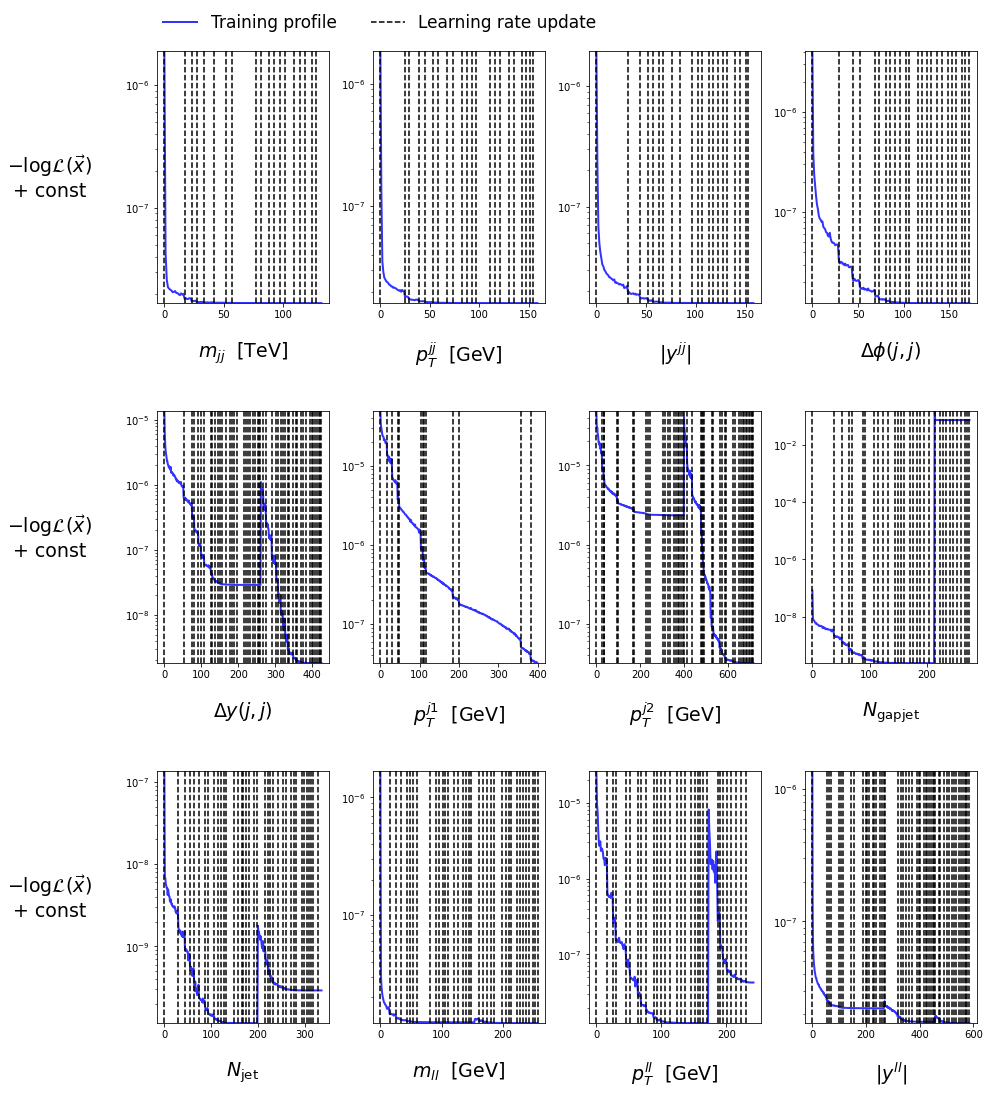

In [126]:
#
#  Call method to produce a plot of the training curves
#

plot_model_training_curves(density_model, savefig=f"figures/Auxilliary/12obs_model_training_curves.pdf")


## 4.  Sampling the density model

To evaluate whether we have done a good job modelling the data, we will draw a large number of samples from density model. We will then compare the distribution of these events with those generated using MG5. To make the subsequent plots exactly reproducible, we allow the newly generated datapoints to be saved and loaded from a file instead.

In [13]:
#============================================================#
#==  Define method for sampling events from density model  ==#
#============================================================#


def generate (model, num_evts, data_table, proj_funcs, num_proc=8) :
    num_evts = num_evts if num_evts > 0 else data_table.get_num_events()
    print(f"Generating {num_evts} fake datapoints")
    start = time.time()
    fake_latent_datapoints = model.sample(num_evts, [1.], n_processes=num_proc)
    end = time.time()
    print(f"{num_evts} datapoints generated in {int(end-start):.0f}s")
    print("Inverting fake datapoints")
    start = time.time()
    fake_datapoints = project_axes_from_latent(fake_latent_datapoints, proj_funcs)
    end = time.time()
    print(f"{num_evts} datapoints inverted in {int(end-start):.0f}s")
    return fake_latent_datapoints, fake_datapoints


In [130]:
#================================================================================#
#==  Load previously sampled events from model, or generate and save new ones  ==#
#================================================================================#

datapoints_fname = f"{model_dir}/plot_0D_datapoints.pickle"
if False : # load_plottable_datapoints :
    print(f"Loading plottable datapoints from file {datapoints_fname}")
    loaded = pickle.load(open(datapoints_fname, "rb"))
    fake_datapoints        = loaded["fake_datapoints"]
    fake_latent_datapoints = loaded["fake_white_datapoints"]
else :
    print("Generating plottable datapoints")
    fake_latent_datapoints, fake_datapoints = generate(density_model, num_evts=4000000, data_table=data_table, proj_funcs=proj_funcs, num_proc=1)
    if save_plottable_datapoints :
        print(f"Saving plottable datapoints to file {datapoints_fname}")
        to_save = {}
        to_save["fake_datapoints"]       = fake_datapoints
        to_save["fake_white_datapoints"] = fake_white_datapoints
        pickle.dump(to_save, open(datapoints_fname, "wb"))        
    

Generating plottable datapoints
Generating 4000000 fake datapoints
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 4
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 5
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 6
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 7
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 8
INFO       DensityModel.sample         Sampling 4000000 datapoints, observable index is 9
INFO       DensityModel.sample   

In [19]:
#================================================================================#
#==  Load previously sampled events from model, or generate and save new ones  ==#
#================================================================================#

datapoints_fname = f"{model_dir}/plot_0D_datapoints.pickle"
if load_plottable_datapoints :
    print(f"Loading plottable datapoints from file {datapoints_fname}")
    loaded = pickle.load(open(datapoints_fname, "rb"))
    fake_datapoints        = loaded["fake_datapoints"]
    fake_latent_datapoints = loaded["fake_white_datapoints"]
else :
    print("Generating plottable datapoints")
    fake_latent_datapoints, fake_datapoints = generate(model, num_evts=num_gen_evts, data_table=data_table, proj_funcs=proj_funcs, num_proc=num_gen_proc)
    if save_plottable_datapoints :
        print(f"Saving plottable datapoints to file {datapoints_fname}")
        to_save = {}
        to_save["fake_datapoints"]       = fake_datapoints
        to_save["fake_white_datapoints"] = fake_white_datapoints
        pickle.dump(to_save, open(datapoints_fname, "wb"))        
    

Loading plottable datapoints from file .EWK_density_model_paper_0D_final_FULL_v7a/plot_0D_datapoints.pickle


##  5.  Prepare for plotting

The following cells define methods which will be used to create the final plots later on.

In [20]:
#==========================================#
#==  Some methods to help with plotting  ==#
#==========================================#
#
#  Method returns list of pairs of observables should be plotted in 2D
#
def get_obs_for_2D_plot (observables) :
    """Return a list of all (x observable index, x observable, y observable index, y observable) tuples
        which we wish to assign to an individual 2D axis"""
    num_observables = len(observables)
    obs_to_plot = []
    for obs_idx_x, obs_x in enumerate(observables) :
        if obs_idx_x == num_observables-1 : continue  #  Don't plot observable -1 on x axis
        for obs_idx_y, obs_y in enumerate(observables) :
            if obs_idx_y == 0         : continue   #  Don't plot observable 0 on y axis
            if obs_idx_y <= obs_idx_x : continue   #  Don't plot above diagonal on y axis
            obs_to_plot.append((obs_idx_x, obs_x, obs_idx_y, obs_y))
    return obs_to_plot
#
#  Method returns list of ticks which should be plotted for a given observable
#
def get_obs_ticks (obs, is_latent=False) :
    """Return a list of ticks which should be plotted for given observable"""
    if is_latent :
        if obs not in VBFZ.int_observables : return np.array([-3, 0, 3])
        return VBFZ.get_obs_ticks(obs)
    return VBFZ.get_obs_ticks(obs)
#
#  Method returns tick labels corresponding to get_obs_ticks()
#
def get_obs_ticklabels (obs, is_latent=False) :
    """Return a list of tick labels corresponding to ticks defined by the get_obs_ticks() method"""
    if is_latent :
        if obs not in VBFZ.int_observables : return np.array(["-3", "0", "3"])
        return VBFZ.get_obs_ticklabels(obs)
    return VBFZ.get_obs_ticklabels(obs)
#
#  Method returns a suggested binning for the presented (possibly weighted) data
#
def get_adaptive_bins(data, weights=None, obs=None, num_increments=100, max_err=0.05, is_latent=False) :
    """Return suggested binning for data with corresponding weights
    obs           : observable name, used to determine limits of distribution
    num_increments: number of equally spaced bins to be initialised before merging begins
    max_err       : target maximum fractional error for any given bin
    is_latent     : bool, whether data is on the latent space"""
    if not is_latent :
        if (type(obs) != type(None)) and (obs == "N_gap_jets") : return np.array([-0.5, 0.5, 2.5])
        if (type(obs) != type(None)) and (obs == "N_jets")     : return np.array([1.5, 2.5, 5.5])
        if obs : limits = VBFZ.observable_limits[obs]
        else   : limits = [np.min(data), np.max(data)]
    elif (obs == "N_gap_jets") : return np.array([-0.5, 0.5, 2.5])
    elif (obs == "N_jets")     : return np.array([1.5, 2.5, 5.5]) - 2.
    else : limits = [-5, 5]
    if type(weights) == type(None) : weights   = np.ones(shape=(len(data),))
    bins = [x for x in np.linspace(limits[0], limits[1], 1+num_increments)]
    keep_merging = True
    while keep_merging :
        vals, _   = np.histogram(data, bins=bins)
        errs      = np.sqrt(vals)
        frac_errs = [x for x in safe_divide(errs, vals, rogue_den=np.inf, rogue_both=np.inf)]
        curr_err  = np.max(frac_errs)
        if len(bins) == 2 :
            keep_merging = False
        elif 0 in frac_errs :
            idx = len(frac_errs) - frac_errs[::-1].index(0) - 1
            del bins[idx]
        elif curr_err < max_err :
            keep_merging = False
        else :
            idx = frac_errs.index(curr_err)
            if   idx == 0             : del bins[1]
            elif idx == len(bins) - 2 : del bins[-2]
            elif frac_errs[idx-1] > frac_errs[idx>1] : del bins[idx]
            else : del bins[idx+1]
    return np.array(bins)


In [108]:
#========================================================#
#==  Method to plot 1D marginal distributions of data  ==#
#========================================================#
#
#  Method creates a plot of the 1D marginal distributions comparing datapoints sampled from the
#       density model with those from MG5
#
def plot_1D_projections (datapoints_num, datapoints_den, weights_num=None, weights_den=None, savefig="", is_latent=False, num_bins=20, max_cols=6) :
    """plot the 1D projections of the datapoints provided"""
    observables      , num_observables = VBFZ.observables      , VBFZ.num_observables
    observable_limits, int_observables = VBFZ.observable_limits, VBFZ.int_observables
    #
    #  If no weights provided then assume uniform
    #
    if type(weights_num) == type(None) : weights_num = np.ones(shape=(datapoints_num.shape[0],))
    if type(weights_den) == type(None) : weights_den = np.ones(shape=(datapoints_den.shape[0],))
    #
    #  Calculate plot dimensions and create figure object
    #
    num_cols = np.min([max_cols, num_observables])
    num_rows = math.ceil(num_observables/num_cols)
    fig      = plt.figure(figsize=(2*num_cols, 6*num_rows))
    #
    #  Loop over subplots
    #
    axes1, axes2 = [], []
    ymins, ymaxs = [], []
    for row_idx in range(num_rows) :
        for col_idx in range(num_cols) :
            obs_idx = num_cols*row_idx + col_idx
            if obs_idx >= num_observables : continue
            observable = observables[obs_idx]
            #
            #  Get axis co-ordinates
            #
            xlo, xwidth  = col_idx/num_cols, 1./num_cols
            ylo, yheight = 1. - (1+row_idx)/num_rows, 1./num_rows
            #
            #  Get values of distributions
            #  -  get binning
            bins       = get_adaptive_bins(datapoints_den[:,obs_idx], weights_den, obs=observable, num_increments=30, max_err=0.02, is_latent=is_latent)
            bin_widths = bins[1:] - bins[:-1]
            #  -  get numerator histo values
            hvals_num, _ = np.histogram(datapoints_num[:,obs_idx], bins=bins, weights=weights_num            )
            herrs_num, _ = np.histogram(datapoints_num[:,obs_idx], bins=bins, weights=weights_num*weights_num)
            herrs_num    = np.sqrt(herrs_num)
            hvals_num, herrs_num = hvals_num/np.sum(weights_num)/bin_widths, herrs_num/np.sum(weights_num)/bin_widths
            norm_vals    = np.max(hvals_num)
            hvals_num, herrs_num = hvals_num / norm_vals, herrs_num / norm_vals
            #  -  get denominator histo values
            hvals_den, _ = np.histogram(datapoints_den[:,obs_idx], bins=bins, weights=weights_den            )
            herrs_den, _ = np.histogram(datapoints_den[:,obs_idx], bins=bins, weights=weights_den*weights_den)
            herrs_den    = np.sqrt(herrs_den)
            hvals_den, herrs_den = hvals_den/np.sum(weights_den)/bin_widths, herrs_den/np.sum(weights_den)/bin_widths
            hvals_den, herrs_den = hvals_den / norm_vals, herrs_den / norm_vals
            #  -  get histograms expressed as lines
            plot_x, plot_y_num, plot_ey_num = histo_to_line(bins, hvals_num, herrs_num)
            _     , plot_y_den, plot_ey_den = histo_to_line(bins, hvals_den, herrs_den)
            #  -  report if any bins are out of range
            h_out_of_range = safe_divide(hvals_num - hvals_den, hvals_den)
            h_out_of_range = [v for v in h_out_of_range if (is_latent and np.fabs(v)>0.1) or (not is_latent and np.fabs(v)>0.05)]
            if len(h_out_of_range) > 0 :
                print(f"WARNING {observable} 1D plot: the following bin values were found: {h_out_of_range}")
            #
            #  Create absolute distribution plot (top panel of each observable)
            #
            ax1 = fig.add_axes([xlo, ylo+0.6*yheight, 0.95*xwidth, 0.38*yheight])
            ax1.plot(plot_x, plot_y_num, "-", color="k"      , linewidth=2, label="Samples from density model")
            ax1.fill_between(plot_x, plot_y_num-plot_ey_num, plot_y_num+plot_ey_num, color="lightgrey", alpha=1)
            ax1.plot(plot_x, plot_y_den, "-", color="darkred", linewidth=2, label="MG5 events")
            ax1.fill_between(plot_x, plot_y_den-plot_ey_den, plot_y_den+plot_ey_den, color="red", alpha=0.2)
            ax1.set_yscale("log")
            #
            #  Save ymin, ymax and top axis for this observable
            #
            ymin, ymax = np.min([plot_y_num-plot_ey_num, plot_y_den-plot_ey_den]), np.max([plot_y_num+plot_ey_num, plot_y_den+plot_ey_den])
            ymins.append(ymin)
            ymaxs.append(ymax)
            axes1.append(ax1)
            #
            #  Create ratio plot (bottom panel of each observable)
            #
            plot_ey_diff = np.sqrt(plot_ey_num*plot_ey_num + plot_ey_den*plot_ey_den)
            ax2 = fig.add_axes([xlo, ylo+0.2*yheight, 0.95*xwidth, 0.38*yheight])
            ax2.axhline(0, c="darkred", linewidth=2)
            ax2.fill_between(plot_x, -safe_divide(plot_ey_den, plot_y_den), safe_divide(plot_ey_den, plot_y_den), color="red", alpha=0.2)
            ax2.plot(plot_x, safe_divide(plot_y_num-plot_y_den, plot_y_den), c="k", linewidth=2)
            ax2.fill_between(plot_x, safe_divide(plot_y_num-plot_ey_num-plot_y_den, plot_y_den), safe_divide(plot_y_num+plot_ey_num-plot_y_den, plot_y_den), color="lightgrey", alpha=0.5)
            axes2.append(ax2)
            #
            #  Set ylim and draw horizontal reference lines
            #
            if is_latent :
                ax2.set_ylim([-0.10, 0.10])
                for h in np.linspace(-0.09, 0.09, 19) :
                    ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            else :
                ax2.set_ylim([-0.06, 0.06])
                for h in np.linspace(-0.05, 0.05, 11) :
                    ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            #  
            #  Set x limits and scale
            #  
            ax1.set_xlim([bins[0], bins[-1]])
            ax2.set_xlim([bins[0], bins[-1]])
            if not is_latent :
                if observable in log_observables :
                    ax1.set_xscale("function", functions=log_axis_functions )
                    ax2.set_xscale("function", functions=log_axis_functions )
            #
            #  Set axis ticks
            #   
            if col_idx > 0 :
                ax1.get_yaxis().set_ticklabels([])
                ax2.get_yaxis().set_ticklabels([])
            ax1.set_xticks(get_obs_ticks(observable, is_latent=is_latent))
            ax2.set_xticks(get_obs_ticks(observable, is_latent=is_latent))
            ax1.get_xaxis().set_ticklabels([])
            ax2.get_xaxis().set_ticklabels(get_obs_ticklabels(observable, is_latent=is_latent))
            #   
            #  Set axis labels
            #   
            ax2.set_xlabel(VBFZ.get_obs_label(observable), fontsize=19, labelpad=20)
            if col_idx == 0 : 
                ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
                ax2.set_ylabel("Ratio to\nMG5", fontsize=19, labelpad=65, rotation=0, va="center")
                if is_latent :
                    ax2.set_yticks     ([-0.08, -0.04, 0, 0.04, 0.08])
                    ax2.set_yticklabels([r"$-8\%$", r"$-4\%$", r"$0$", r"$+4\%$", r"$+8\%$"])
                else :
                    ax2.set_yticks     ([-0.04, -0.02, 0, 0.02, 0.04])
                    ax2.set_yticklabels([r"$-4\%$", r"$-2\%$", r"$0$", r"$+2\%$", r"$+4\%$"])
            #  
            #  Set tick params
            #  
            ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
            ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    #
    #  Set consistent axis y lims
    #
    ymin, ymax = np.min([y for y in ymins if y > 0])/2., 2.*np.max(ymaxs)
    for ax in axes1 :
        ax.set_ylim([ymin, ymax])
    #
    #  Set y-axis ticks and legend
    #
    leg_proxy  = [lines.Line2D([], [], color='black' , linestyle='-', lw=2, alpha=1),
                  plt.Rectangle((0,0),1,1,fc="red",ec="darkred",lw=2,ls="-",alpha=0.2)]
    leg_labels = ["Samples from density model", "MG5 events"]
    axes1[0].legend(leg_proxy, leg_labels, loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
    #
    #  Save and show figure
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()
        

In [22]:
#========================================================#
#==  Method to plot 2D marginal distributions of data  ==#
#========================================================#
#
#  Method creates a plot of the 2D marginal distributions of datapoints provided
#
def plot_2D_projections (datapoints, weights=None, bins_data=None, bins_weights=None, label="", savefig="", is_latent=False, num_bins=20, vmin=1e-5) :
    """plot the 2D projections of the datapoints provided"""
    observables      , num_observables = VBFZ.observables      , VBFZ.num_observables
    observable_limits, int_observables = VBFZ.observable_limits, VBFZ.int_observables
    #
    #  If no weights provided then assume uniform
    #
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    #
    #  Resolve which data to generate bins from
    #
    if type(bins_data) == type(None) :
        bins_data = datapoints
        if type(bins_weights) == type(None) :
            bins_weights = weights
    elif type(bins_weights) == type(None) :
        bins_weights = np.ones(shape=(bins_data.shape[0],))
    #
    #  Save the list of indices to plot (to make sure all loops are over consistent sets)
    #
    obs_to_plot = get_obs_for_2D_plot (observables)
    #
    #  Make plot
    #
    fig = plt.figure(figsize=(20, 14))
    for obs_idx_x, obs_x, obs_idx_y, obs_y in obs_to_plot :
        xlo    = obs_idx_x / (num_observables-1)    #  Get axis x coordinates
        xwidth = 1.        / (num_observables-1)
        ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)   #  Get axis y coordinates
        yheight = 1.                            / (num_observables-1)
        #
        #  Create axis
        #
        ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])
        #
        #  Format log axes
        #
        if not is_latent :
            if obs_x in log_observables : ax.set_xscale("function", functions=log_axis_functions )
            if obs_y in log_observables : ax.set_yscale("function", functions=log_axis_functions )
        #
        #  Draw axis ticks and labels
        #
        ax.set_xticks(get_obs_ticks(obs_x, is_latent=is_latent))
        ax.set_yticks(get_obs_ticks(obs_y, is_latent=is_latent))
        if obs_idx_y == num_observables-1 : 
            ax.get_xaxis().set_ticklabels(get_obs_ticklabels(obs_x, is_latent=is_latent))
            ax.set_xlabel(VBFZ.get_obs_label(obs_x).replace("  [","\n["), fontsize=19, labelpad=20, va="top", ha="center")
        else :
            ax.get_xaxis().set_ticklabels([])
        if obs_idx_x == 0 : 
            ax.get_yaxis().set_ticklabels(get_obs_ticklabels(obs_y, is_latent=is_latent))
            ax.set_ylabel(VBFZ.get_obs_label(obs_y).replace("  [","\n["), fontsize=19, labelpad=20, rotation=0, va="center", ha="right")
        else :
            ax.get_yaxis().set_ticklabels([])
        #
        #  Format tick params
        #
        ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        #
        #  Draw histogram
        #
        bins_x = get_adaptive_bins(bins_data[:,obs_idx_x], bins_weights, obs=obs_x, num_increments=30, max_err=0.02, is_latent=is_latent)
        bins_y = get_adaptive_bins(bins_data[:,obs_idx_y], bins_weights, obs=obs_y, num_increments=30, max_err=0.02, is_latent=is_latent)
        hist_vals, _, _  = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y), density=True)
        norm_const       = np.nanmax(hist_vals.flatten())
        h, _, _, patches = ax.hist2d     (datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y), density=True, vmin=vmin*norm_const, vmax=norm_const, norm=colors.LogNorm(), cmap="inferno")
        #
        #  Draw label
        #
        if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
            ax.text(0, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=21)
    #
    #  Draw colour bar
    #
    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks(np.array([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])*norm_const)
    cbar   .set_ticklabels(["100%", "10%", "1%", "0.1%", "0.01%", "0.001%"])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")
    #
    #  Save and show plot
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()
        

In [23]:
#============================================================#
#==  Method to plot ratio of marginal distributions in 2D  ==#
#============================================================#
#
#  Method creates a plot of the 2D marginal distributions of datapoints provided
#
def plot_2D_ratios (datapoints_num, datapoints_den, weights_num=None, weights_den=None, savefig="", is_latent=False, num_bins=20) :
    observables      , num_observables = VBFZ.observables      , VBFZ.num_observables
    observable_limits, int_observables = VBFZ.observable_limits, VBFZ.int_observables
    #
    #  If no weights provided then assume uniform
    #
    if type(weights_num) == type(None) : weights_num = np.ones(shape=(datapoints_num.shape[0],))
    if type(weights_den) == type(None) : weights_den = np.ones(shape=(datapoints_den.shape[0],))
    #
    #  Save the list of indices to plot (to make sure all loops are over consistent sets)
    #
    obs_to_plot = get_obs_for_2D_plot (observables)
    #
    #  Make plot
    #
    fig = plt.figure(figsize=(20, 14))
    vmin = 1e-5
    for obs_idx_x, obs_x, obs_idx_y, obs_y in obs_to_plot :
        xlo    = obs_idx_x / (num_observables-1)    #  Get axis x coordinates
        xwidth = 1.        / (num_observables-1)
        ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)   #  Get axis y coordinates
        yheight = 1.                            / (num_observables-1)
        #
        #  Create axis
        #
        ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])
        #
        #  Format log axes
        #
        if not is_latent :
            if obs_x in log_observables : ax.set_xscale("function", functions=log_axis_functions )
            if obs_y in log_observables : ax.set_yscale("function", functions=log_axis_functions )
        #
        #  Draw axis ticks and labels
        #
        ax.set_xticks(get_obs_ticks(obs_x, is_latent=is_latent))
        ax.set_yticks(get_obs_ticks(obs_y, is_latent=is_latent))
        if obs_idx_y == num_observables-1 : 
            ax.get_xaxis().set_ticklabels(get_obs_ticklabels(obs_x, is_latent=is_latent))
            ax.set_xlabel(VBFZ.get_obs_label(obs_x).replace("  [","\n["), fontsize=19, labelpad=20, va="top", ha="center")
        else :
            ax.get_xaxis().set_ticklabels([])
        if obs_idx_x == 0 : 
            ax.get_yaxis().set_ticklabels(get_obs_ticklabels(obs_y, is_latent=is_latent))
            ax.set_ylabel(VBFZ.get_obs_label(obs_y).replace("  [","\n["), fontsize=19, labelpad=20, rotation=0, va="center", ha="right")
        else :
            ax.get_yaxis().set_ticklabels([])
        #
        #  Format tick params
        #
        ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        #
        #  Draw histogram
        #
        bins_x = get_adaptive_bins(datapoints_den[:,obs_idx_x], weights_den, obs=obs_x, num_increments=30, max_err=0.02, is_latent=is_latent)
        bins_y = get_adaptive_bins(datapoints_den[:,obs_idx_y], weights_den, obs=obs_y, num_increments=30, max_err=0.02, is_latent=is_latent)
        X, Y, ratio, ratio_err = get_ratio_2D (datapoints_den[:,obs_idx_x], datapoints_den[:,obs_idx_y],
                                               datapoints_num[:,obs_idx_x], datapoints_num[:,obs_idx_y],
                                               bins_x, bins_y, weights1=weights_den, weights2=weights_num) 
        rat_infs = np.array([[0. if v != np.inf else 1. for v in row] for row in ratio])
        
        ratio_err = np.array([[0. if v == np.inf else v for v in row] for row in np.fabs(ratio_err)])
        pulls     = safe_divide(ratio-1, ratio_err, rogue_den=np.inf, rogue_both=np.nan)
        
        im2 = ax.pcolormesh(X, Y, rat_infs.transpose(), cmap=plt.get_cmap("Greys"))
        im  = ax.pcolormesh(X, Y, pulls   .transpose(), cmap=custom_colormap_list, vmin=-4, vmax=4)
    #
    #  Draw colour bar
    #
    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(im, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    cbar   .set_label(r"Pull on $\frac{p_{\rm model}(x)}{p_{\rm MG5}(x)}$", fontsize=25, labelpad=105, rotation=0, va="center")
    #
    #  Save and show plot
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()

##  6. Plot 1D marginal distributions

We now make the plot comparing the 1D marginal distributions. The first plot considers data on the physical space, corresponding to Figure 4 of the paper. We note that agreement of the density model and MG5 shown in each distribution does not represent how well a single observable is modelled, rather how well the 12 dimensional model performs when projected in that direction.

WARNING N_gap_jets 1D plot: the following bin values were found: [-1.0]
WARNING N_jets 1D plot: the following bin values were found: [-0.6760448760201776]


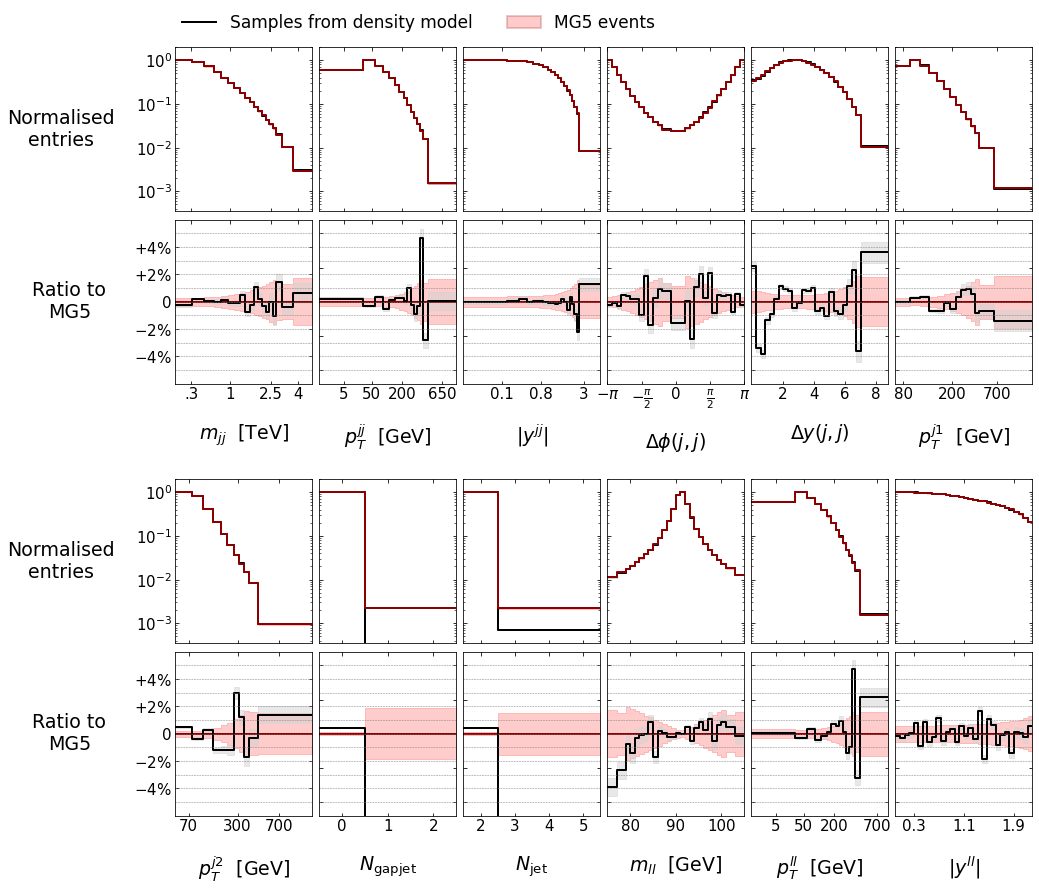

In [131]:
#==========================================================#
#==  Plot 1D distribution of data in the physical space  ==#
#==========================================================#
#
plot_1D_projections(fake_datapoints, 
                    observable_data[1.], 
                    weights_den=data_weights[1.],
                    is_latent=False,
                    savefig="figures/Figure4/Fig4.pdf")


As a cross check, we now plot the same thing in the latent space. This shows that the systematic deviations observed in the above plot (on the physical space) are dominated by underfitting in the tails of the distributions on the latent space. In some cases (e.g. $\Delta y \left(j,j\right)$ and $p_{T}^{j2}$) the ratio appears to diverge. However, it should be noted that _these bins correspond to a very low probability density_ and so, in real data, there will be _very few events impacted_ by these divergences.

In fact, these systematic deviations are observed in this region _because_ they have such a small impact on real events: when training, the $\log\mathcal{L}$ is improved by achieving excellent modelling in the bulk of the data; in the tails, systematic mismodelling has less impact on the total $\log\mathcal{L}$ and so is more tolerable. In the very extremes, the ratio between two very small numbers appears to diverge. Nevertheless, the integrated density in these regions may be sufficient to impact on a parameter estimation exercise. We anticpate that more sophisticated training regimens which improve the modelling of the tails may mitigate this.

WARNING N_gap_jets 1D plot: the following bin values were found: [-1.0]


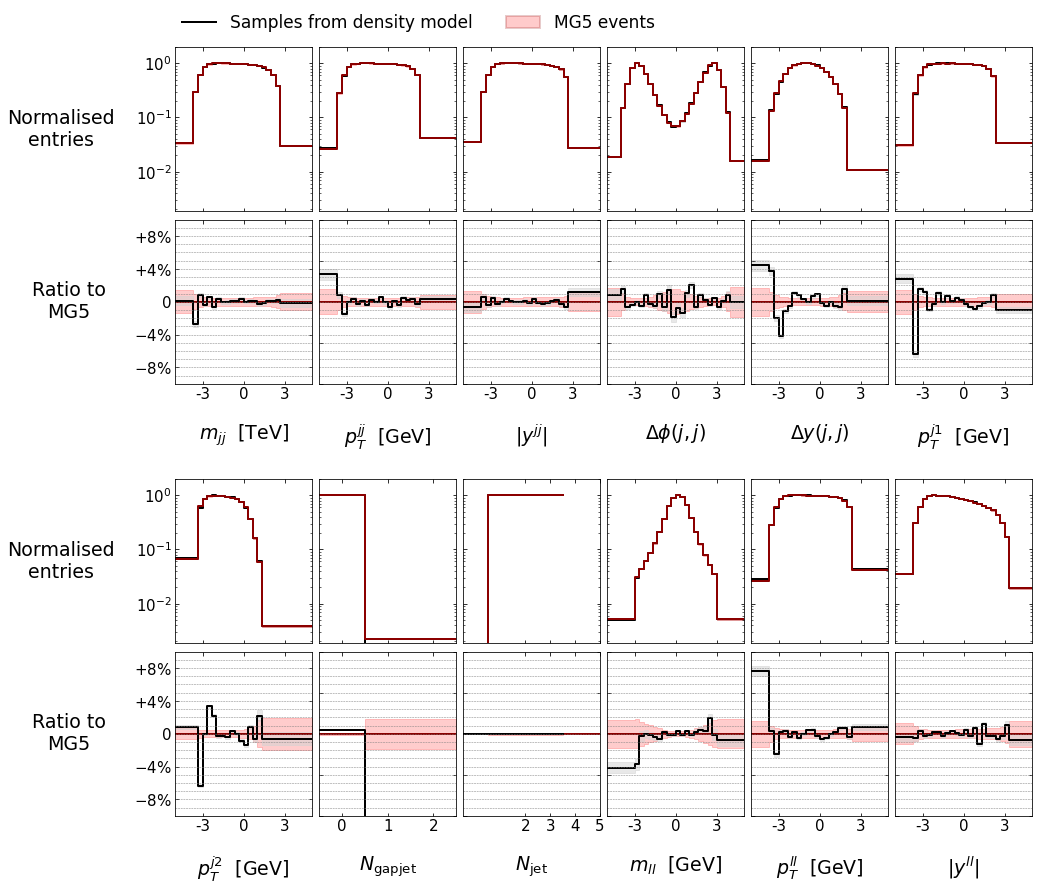

In [132]:
#========================================================#
#==  Plot 1D distribution of data in the latent space  ==#
#========================================================#
#
plot_1D_projections(fake_latent_datapoints, 
                    latent_data[1.], 
                    weights_den=data_weights[1.], 
                    is_latent=True,
                    savefig="figures/Auxilliary/12obs_1D_marginal_dist_latent.pdf")

##  7. Plot 2D marginal distributions on the latent space

We now plot the 2D marginal distributions of the model-sampled and MG5 data in 2D. There are $12$ observables, and so $12 \times 11$ directions in which to project. Since it is difficult to present the ratio between the distributions on the same plot, we will save this for later. For now we plot the model-sampled and MG5 events in separate plots. If we have done a good job, these two plots will appear very similar. First we will study these projections on the latent space.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


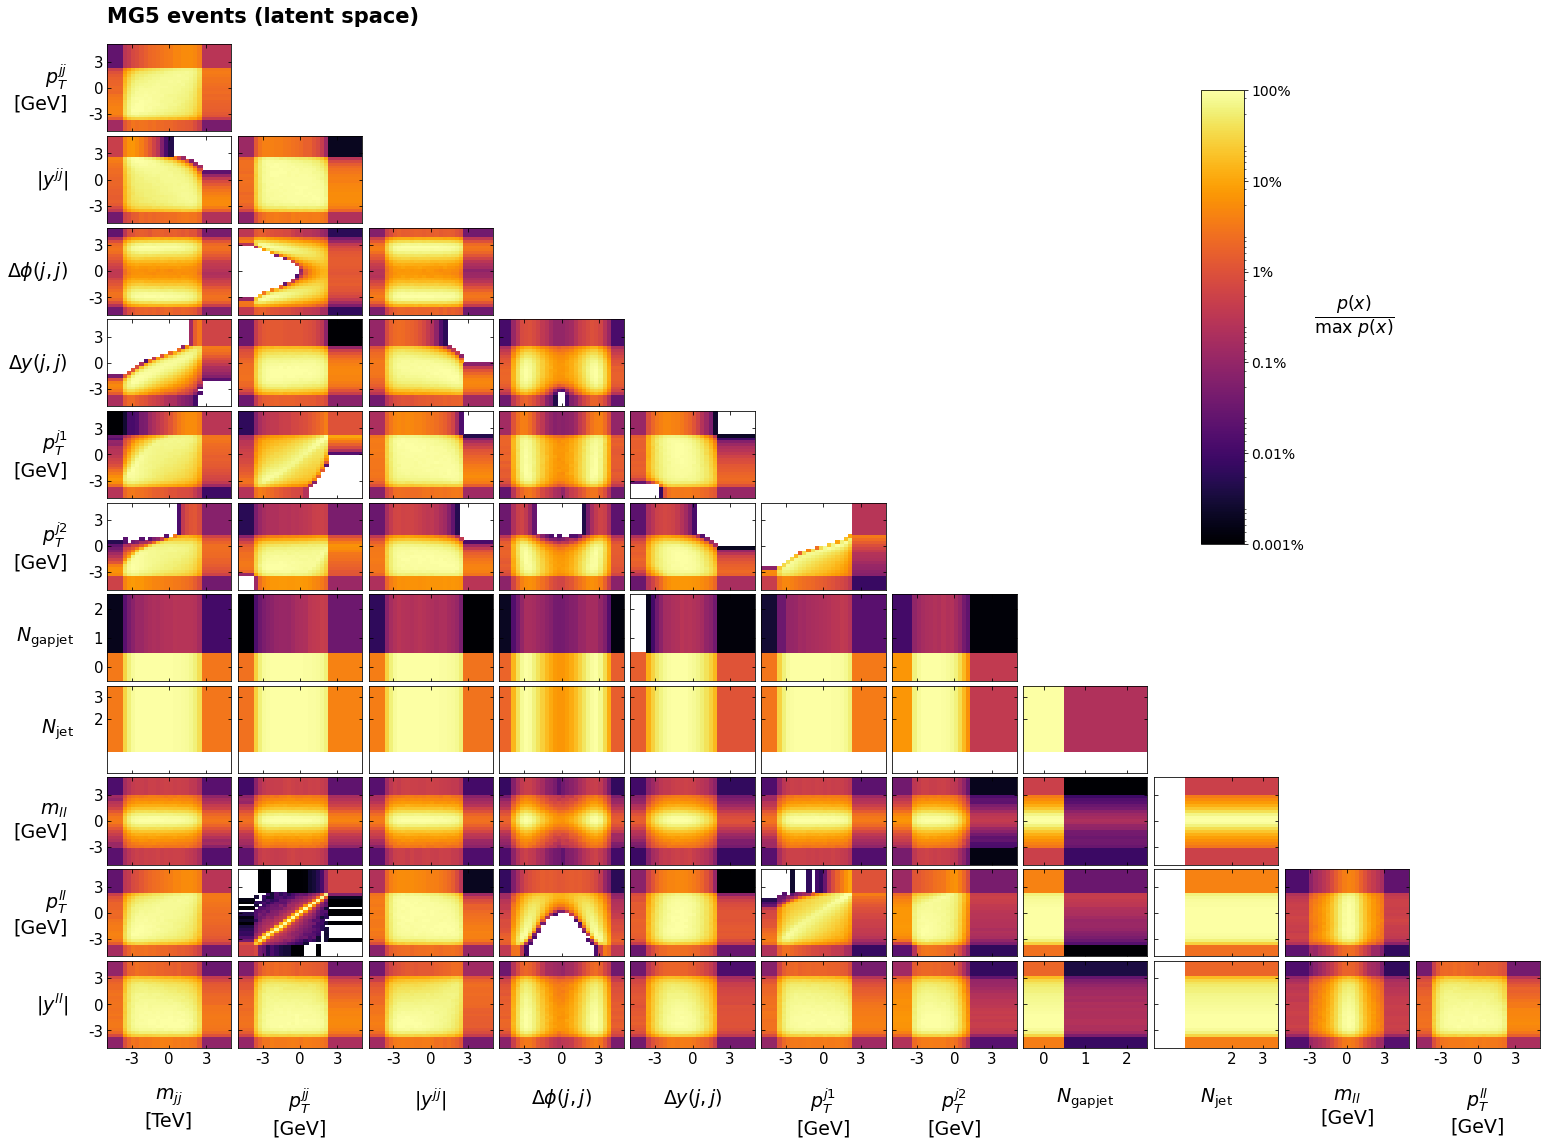

In [136]:
#==============================================================#
#==  Plot 2D distribution of data in the latent space (MG5)  ==#
#==============================================================#
#
plot_2D_projections(latent_data[1.], 
                    weights=data_weights[1.], 
                    is_latent=True, 
                    label="MG5 events (latent space)",
                    savefig="figures/Auxilliary/12obs_2D_marginal_dist_MG5_latent.pdf")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


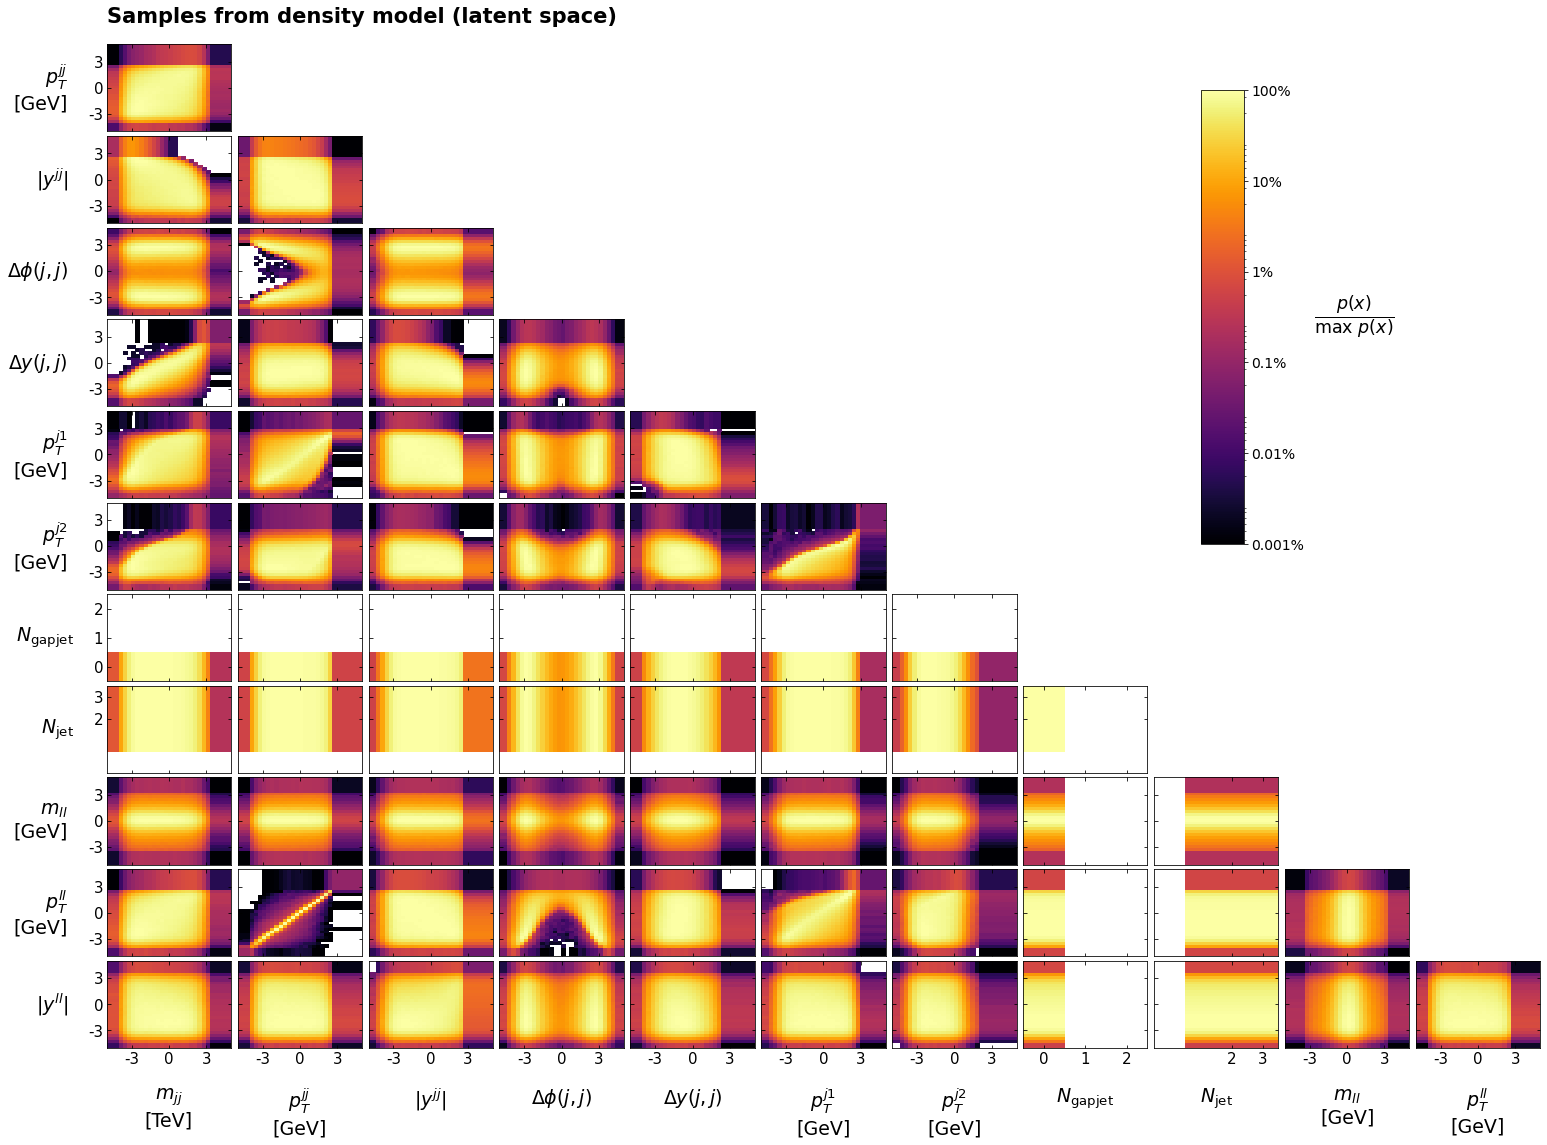

In [137]:
#========================================================================#
#==  Plot 2D distribution of data in the latent space (density model)  ==#
#========================================================================#
#
plot_2D_projections(fake_latent_datapoints, 
                    is_latent=True, 
                    label="Samples from density model (latent space)",
                    savefig="figures/Auxilliary/12obs_2D_marginal_dist_model_latent.pdf")

Now we will compare the two 2D plots in a quantitative way. Studying the ratio is hard to read in 2D, partly because we rely on colour scales, and partly because the ratio is dominated by statistical fluctuations. Instead we will plot the _pull_, defined as
\begin{equation}
\text{Pull} ~=~ \frac{\frac{Model}{MG5}}{\text{Uncertainty on}\frac{Model}{MG5}}
\end{equation}
If all variance is due to random fluctuations, we expect a pull of at least $1$ in magnitude in $32~\%$ of bins, at least $2$ in $5~\%$ of bins and at least $3$ in $0.3~\%$. Since this plot is 2D, we will separate different magnitudes of pull into different coloured regions. Pulls of less than $1$ are coloured in green. Positive pulls above $1$ are shown in increasingly dark shades of red, and negative pulls below $-1$ in blue.

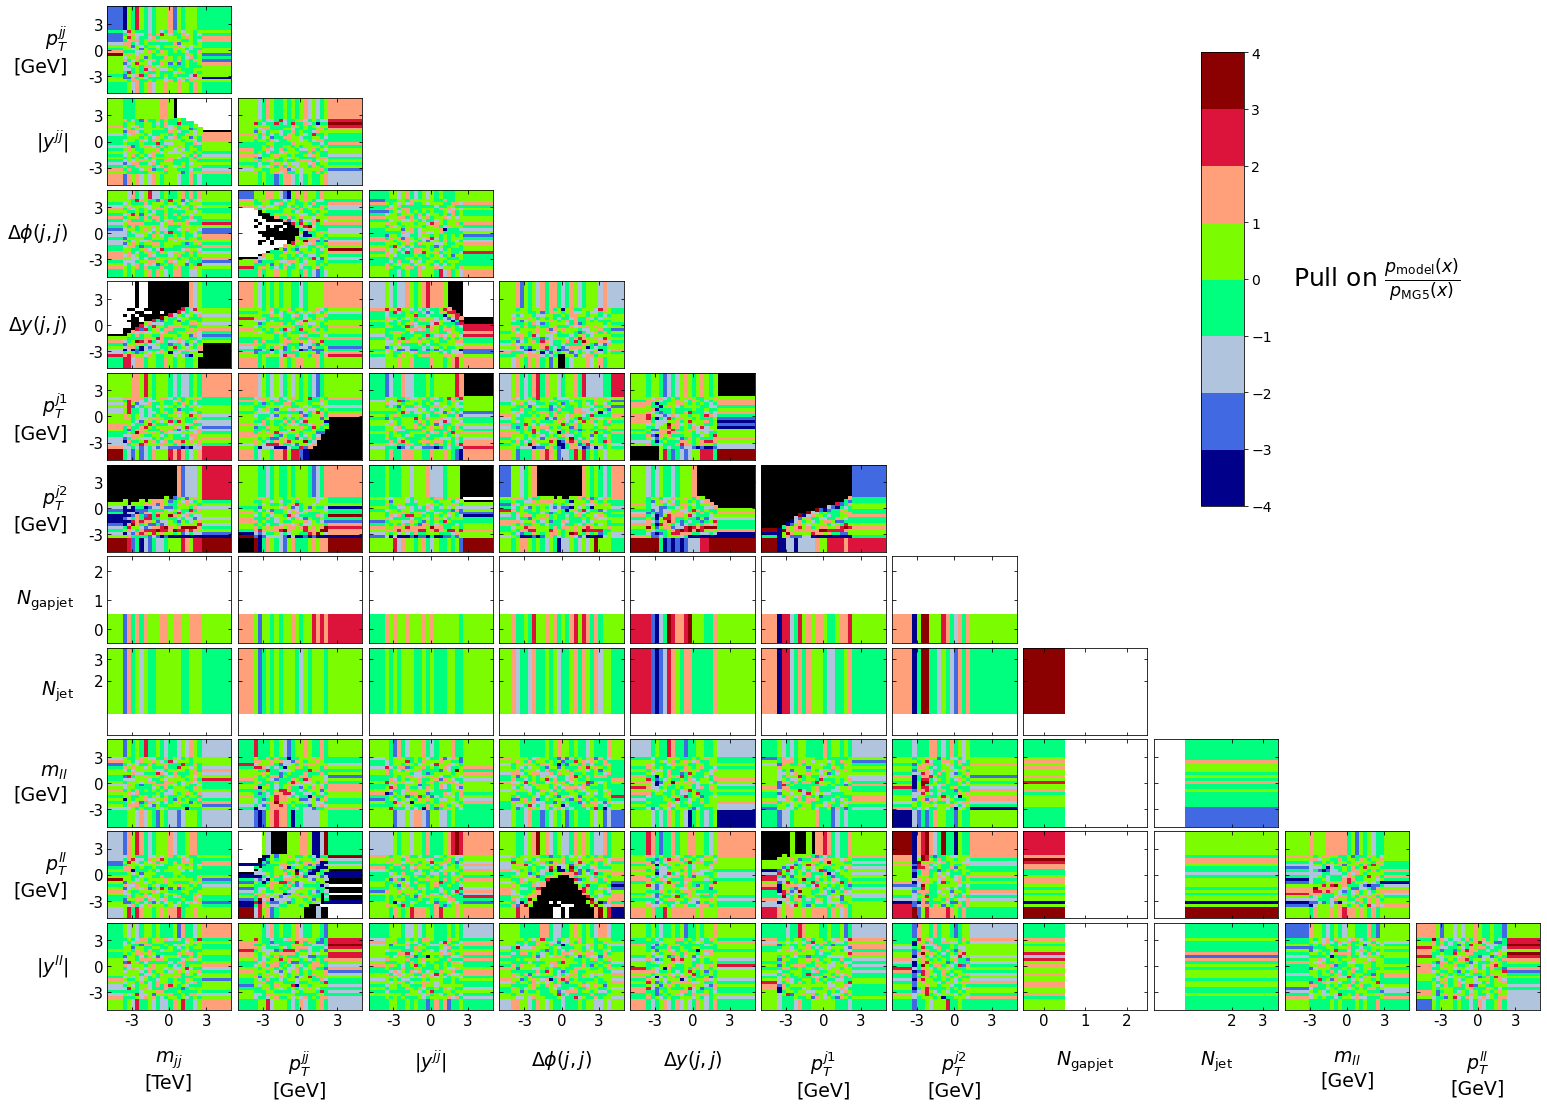

In [138]:
#================================================================#
#==  Plot 2D distribution of data in the latent space (ratio)  ==#
#================================================================#
#
plot_2D_ratios(fake_latent_datapoints, 
               latent_data[1.], 
               weights_den=data_weights[1.], 
               is_latent=True,
               savefig="figures/Auxilliary/12obs_2D_marginal_dist_ratio_latent.pdf")


##  7. Plot 2D marginal distributions on the physical space

We now plot the 2D marginal distributions, and the pull between them, on the physical space. These plots correspond to Figure 5-7 of the paper.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


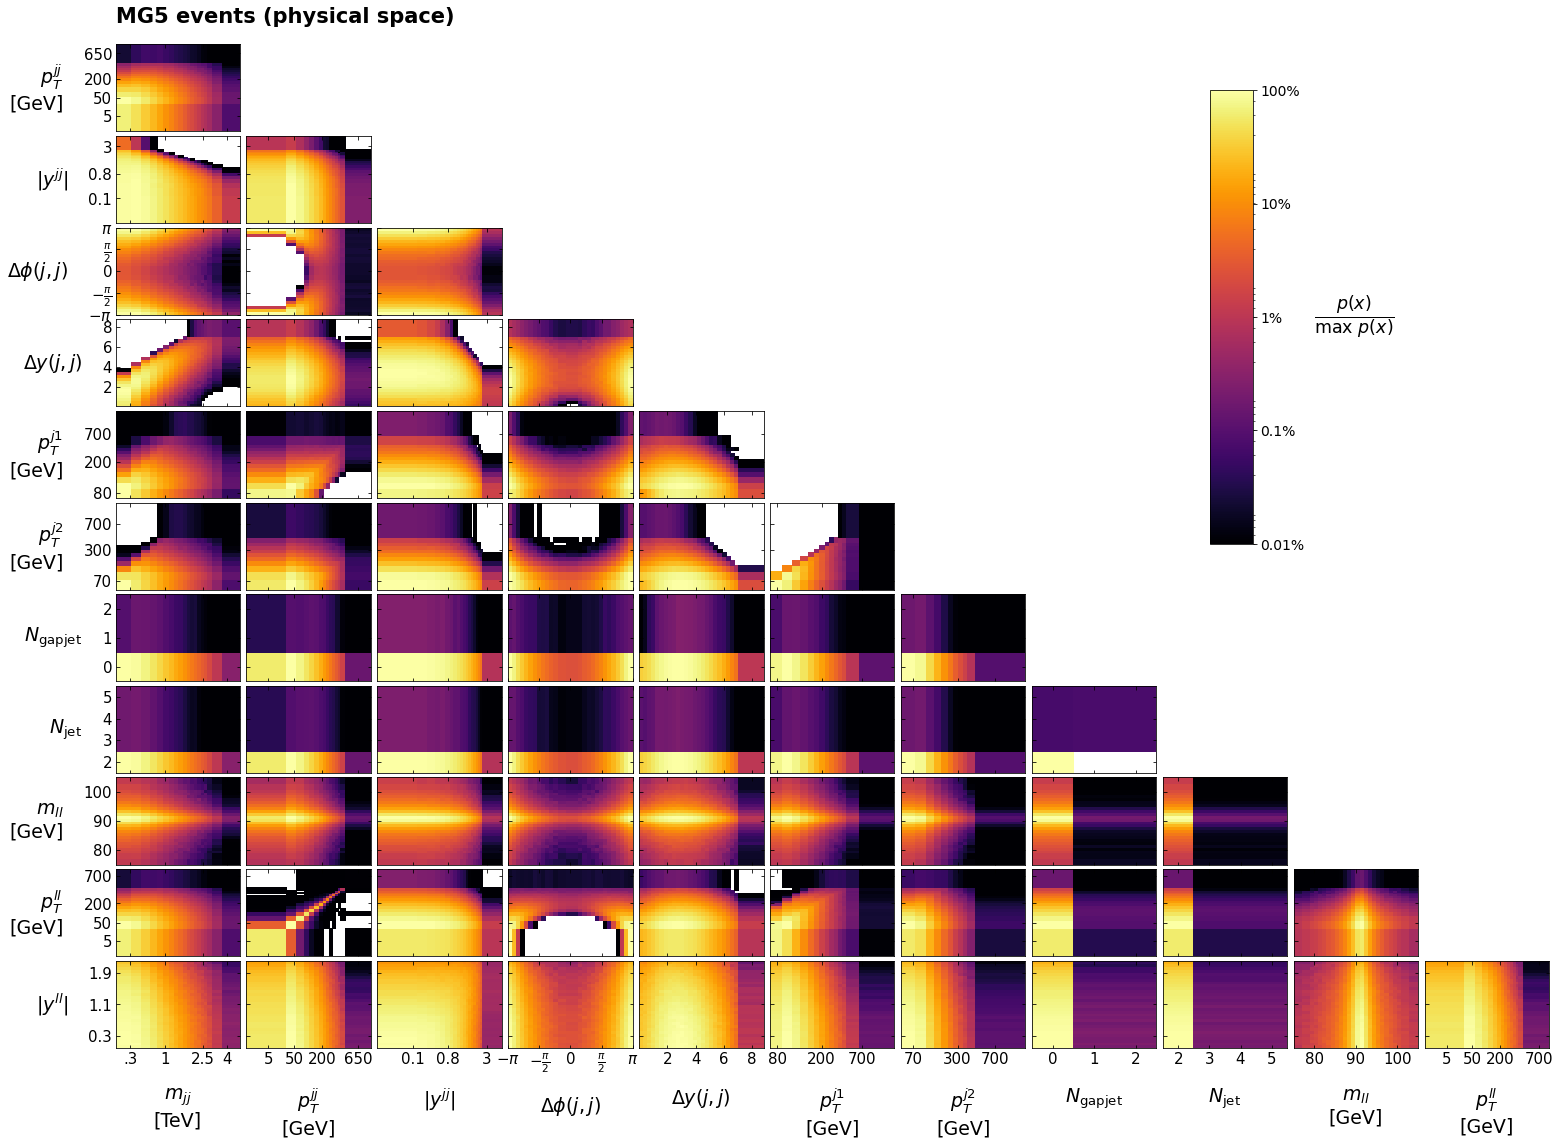

In [139]:
#================================================================#
#==  Plot 2D distribution of data in the physical space (MG5)  ==#
#================================================================#
#
plot_2D_projections(observable_data[1.], 
                    weights=data_weights[1.], 
                    is_latent=False, 
                    label="MG5 events (physical space)",
                    vmin=1e-4,
                    savefig="figures/Figure5/Fig5.pdf")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


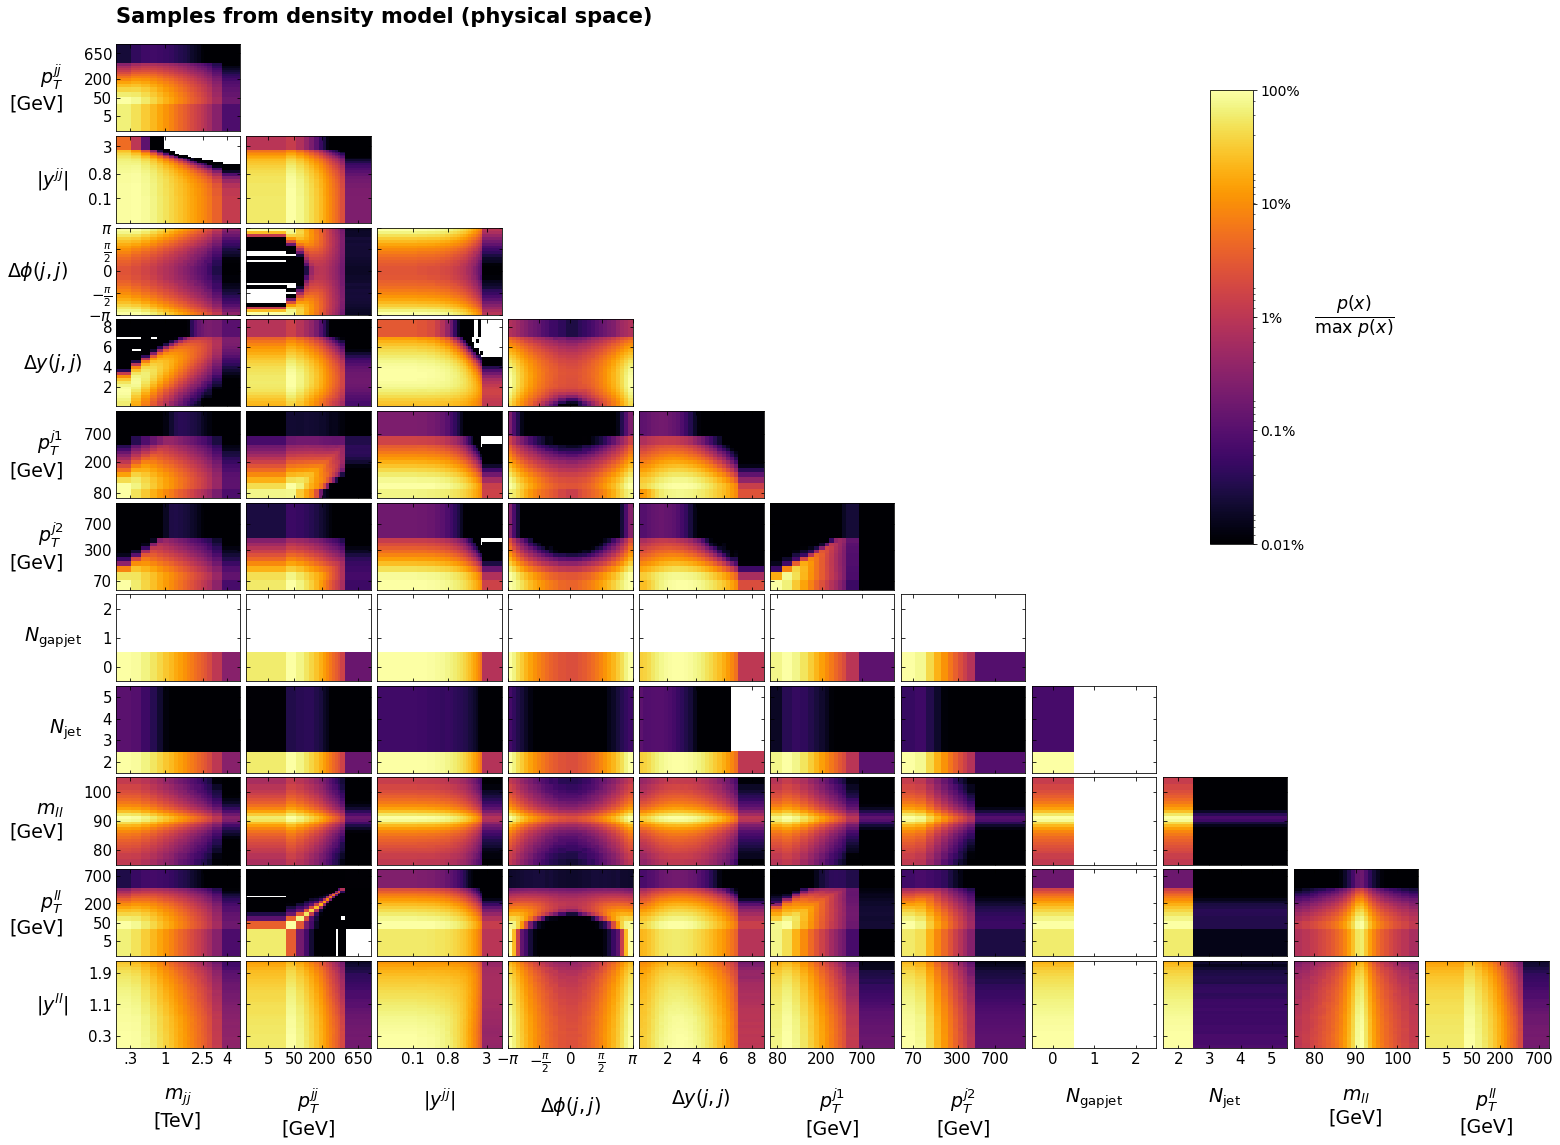

In [140]:
#==========================================================================#
#==  Plot 2D distribution of data in the physical space (density model)  ==#
#==========================================================================#
#
plot_2D_projections(fake_datapoints, 
                    is_latent=False,
                    bins_data=observable_data[1.], 
                    bins_weights=data_weights[1.],
                    label="Samples from density model (physical space)",
                    vmin=1e-4,
                    savefig="figures/Figure6/Fig6.pdf")

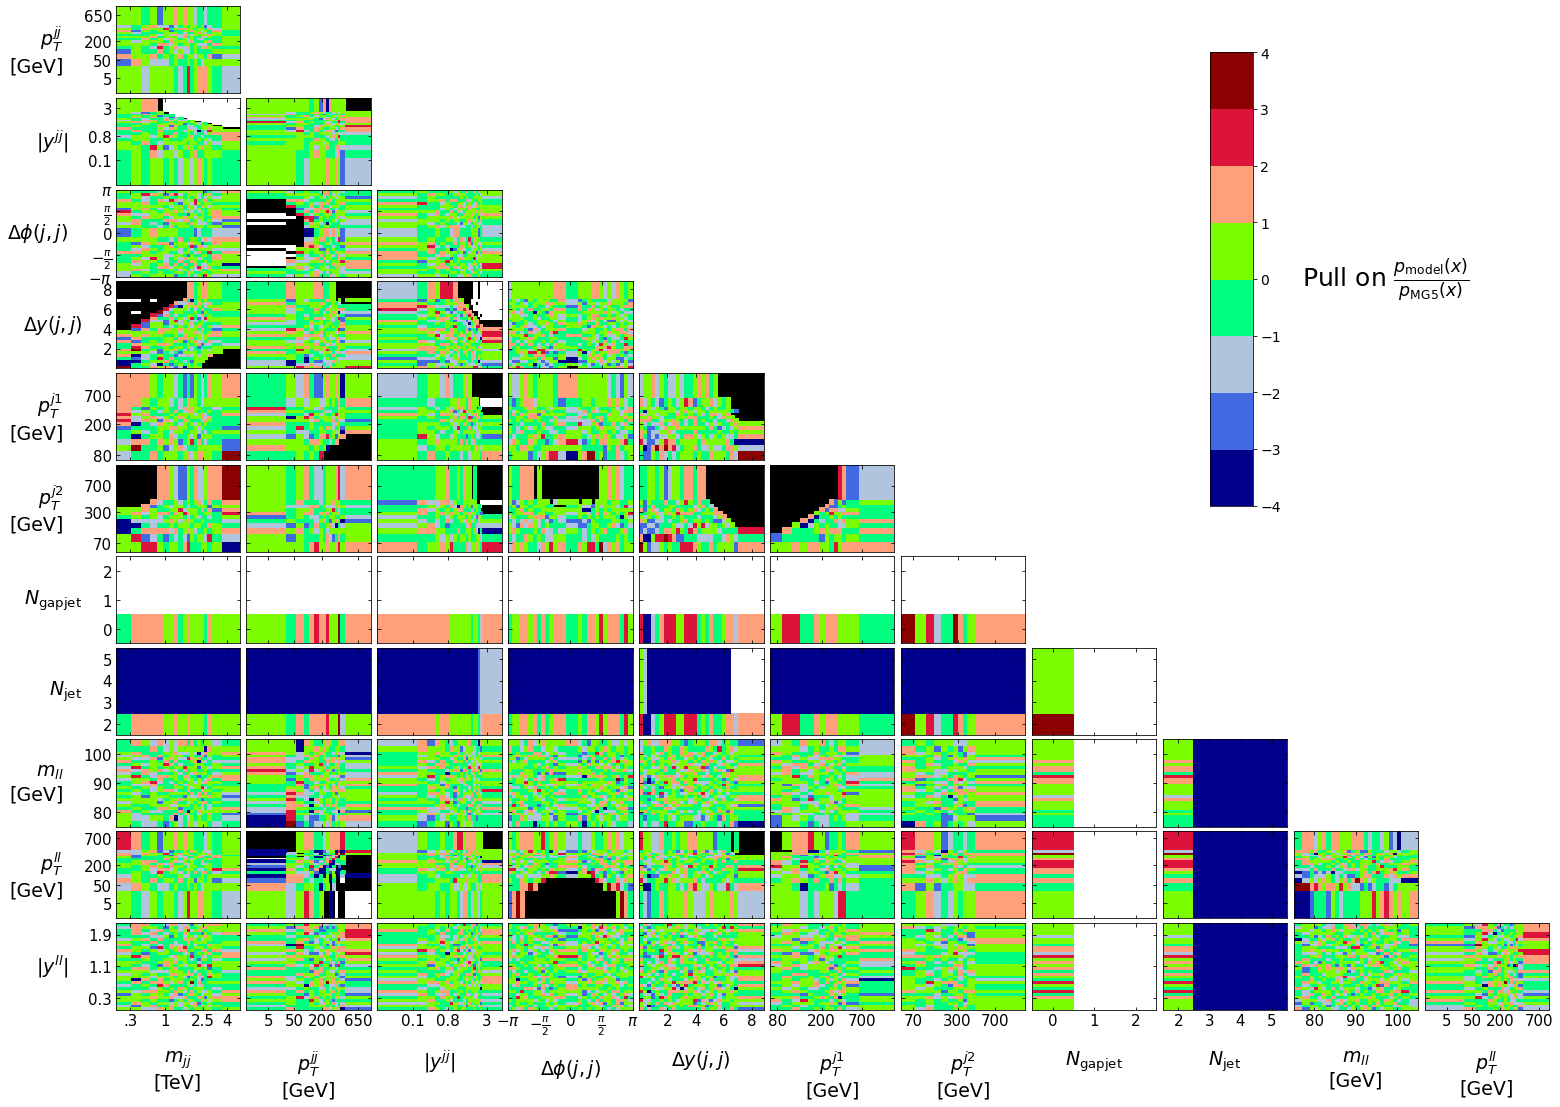

In [141]:
#==================================================================#
#==  Plot 2D distribution of data in the physical space (ratio)  ==#
#==================================================================#
#
plot_2D_ratios(fake_datapoints, 
               observable_data[1.], 
               weights_den=data_weights[1.], 
               is_latent=False,
               savefig="figures/Figure7/Fig7.pdf")